# Factorization machine in TensorFlow 2

Example implementing a factorization machine in TensorFlow 2 using eager computation.

To oversimplify, factorization machines are like linear/logistic regression models, but with an added set of weights, *V*, that models polynomial interactions in a lower dimensional space. They're particualry suited to very sparse inputs, such as user-item ratings for reccomendation systems.

This is based on the theory and tf-1 code in [this article](http://nowave.it/factorization-machines-with-tensorflow.html) by Gabriele Modena and the paper by [Factorization Machines](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf) by Steffen Rendle. Please refer to these articles for much more detailed descriptions of the model, and the maths that avoid O(p<sup>2</sup>).

Note this is early version of the model so may well contain mistakes. Also to avoid having to deal with TFs typing, everything is cast into double precision for now.

In [1]:
import tensorflow as tf
from typing import Callable, Dict, Any
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
print(tf.test.is_gpu_available())
tf.keras.backend.clear_session()


C:\envs\TF2FactorizationMachine\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\envs\TF2FactorizationMachine\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\envs\TF2FactorizationMachine\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\envs\TF2FactorizationMachine\lib\site-packages\tensorflow\python\framework\dtypes.

2.0.0-beta1
True


# Toy data example

This data is modified slightly from:
http://nowave.it/factorization-machines-with-tensorflow.html
http://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf

It contains user and item information required for collaborative filtering (and also some additional features). One hot encoded where appropriate. Ratings are explicit 1-5.

| Users | Movies | Movie ratings | Time | Last movies rated | Rating |
|---|---|---|---|---|--|
| **[A, B, C]** | **[TI, NH, SW, ST]** | **[TI, NH, SW, ST]** | **[T]** | **[TI, NH, SW, ST]** | **[R]** | 
| [1, 0, 0] | [1,  0,  0,  0] | [0.3, 0.3, 0.3, 0.0] |  13 |  [0,  0,  0,  0 ] | 5 | 
| [1, 0, 0] | [0,  1,  0,  0] | [0.3, 0.3, 0.3, 0.0] |  14 |  [1,  0,  0,  0 ] | 3 |
| [1, 0, 0] | [0,  0,  1,  0] | [0.3, 0.3, 0.3, 0.0] |  16 |  [0,  1,  0,  0 ] | 1 |
| [0, 1, 0] | [0,  0,  1,  0] | [0.0, 0.0, 0.5, 0.5] |  5  |  [0,  0,  0,  0 ] | 4 |
| [0, 1, 0] | [0,  0,  0,  1] | [0.0, 0.0, 0.5, 0.5] |  8  |  [0,  0,  1,  0 ] | 5 |
| [0, 0, 1] | [1,  0,  0,  0] | [0.5, 0.0, 0.5, 0.0] |  9  |  [0,  0,  0,  0 ] | 1 |
| [0, 0, 1] | [0,  0,  1,  0] | [0.5, 0.0, 0.5, 0.0] |  12 |  [1,  0,  0,  0 ] | 5 |


In [2]:
# Features
x = np.array([[1, 0, 0,  1, 0, 0, 0,  0.3, 0.3, 0.3, 0.0,  13,  0, 0, 0, 0 ],
              [1, 0, 0,  0, 1, 0, 0,  0.3, 0.3, 0.3, 0.0,  14,  1, 0, 0, 0 ],
              [1, 0, 0,  0, 0, 1, 0,  0.3, 0.3, 0.3, 0.0,  16,  0, 1, 0, 0 ],
              [0, 1, 0,  0, 0, 1, 0,  0.0, 0.0, 0.5, 0.5,  5,   0, 0, 0, 0 ],
              [0, 1, 0,  0, 0, 0, 1,  0.0, 0.0, 0.5, 0.5,  8,   0, 0, 1, 0 ],
              [0, 0, 1,  1, 0, 0, 0,  0.5, 0.0, 0.5, 0.0,  9,   0, 0, 0, 0 ],
              [0, 0, 1,  0, 0, 1, 0,  0.5, 0.0, 0.5, 0.0,  12,  1, 0, 0, 0 ]])

# Targets (explicit rating)
y = np.array([5, 3, 1, 4, 5, 1, 5])
y.shape = (7, 1)

print(x.shape)
print(y.shape)


(7, 16)
(7, 1)


In [3]:
class FactorizationMachine:
    def __init__(self, 
                 m: int=2,
                 k: int=5):
        """
        Initialise coefficients. 
        
        For now:
         - Requires manual specification of feature space dimensionality. 
         - Coefficients are all float64. Might be overkill but it simplifies casting.
        
        :param m: Number of features.
        :param k: Number of latent factors to model in V.
        """
        self.b = tf.Variable(tf.zeros([1], 
                                      dtype='double'))
        self.w = tf.Variable(tf.random.normal(([m]), 
                                              stddev=0.01, 
                                              dtype='double'))
        self.v = tf.Variable(tf.random.normal(([k, m]), 
                                              stddev=0.01, 
                                              dtype='double'))
        
    
    def __call__(self, x: tf.Tensor):
        """
        Predict from model.
        
        :param x: Tensor containing features. 
        :return: Tensor containing predictions.
        """
        
        # Linear terms
        linear = tf.reduce_sum(tf.multiply(self.w, x), 
                                           axis=1, 
                                           keepdims=True)

        # Interaction terms
        interactions = tf.multiply(0.5, tf.reduce_sum(tf.subtract(tf.pow(tf.matmul(x, tf.transpose(self.v)), 2),
                                                      tf.matmul(tf.pow(x, 2), tf.transpose(tf.pow(self.v, 2)))),
                                                      axis=1, 
                                                      keepdims=True))

        # Linear sum along with intercept
        wv = tf.add(linear, interactions)
        bwv = tf.add(self.b, wv)
        
        return bwv
    
    
mod = FactorizationMachine()

## Define loss and training step

The loss here is just least square error.

The training step calculates the current model loss and automatically calculates and records the gradients using tf.GradientTape. The model coefficients are updated using these gradients and the learning rate.

In [4]:
def l2_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def train_step(mod, x, y_true, lr,
               loss_f: Callable=l2_loss):
   
    # Calculate current loss and record gradients
    with tf.GradientTape() as t:
        cur_loss = loss_f(y_true=y_true,
                          y_pred=mod(x))
        
    # Get the gradients and assign to model
    db, dw, dv = t.gradient(cur_loss, [mod.b, mod.w, mod.v])
    mod.b.assign_sub(lr * db)
    mod.w.assign_sub(lr * dw)
    mod.v.assign_sub(lr * dv)

    return cur_loss

## Train model

Training is done by iterating over the toy data a few times; there's no optimizer used here. Loss and the first elements of W and V are logged on each iteration.

In [5]:
# Reset model
mod = FactorizationMachine(m=16)

epochs = 200
bs, ws, vs, losses = [], [], [], []

for e in range(epochs):
    
    cur_loss = train_step(mod=mod, 
                     x=x, 
                     y_true=y,
                     lr=0.0025,
                     loss_f=l2_loss)
    
    # Logging
    losses.append(cur_loss)
    bs.append(mod.b.numpy()[0])
    # Just logging changes in first terms here
    ws.append(mod.w.numpy()[0])
    vs.append(mod.v.numpy()[0])
    
    # Sometimes plot loss
    if (e > 1) & (e % 10 == 0):
        print(f"Epoch {e + 1} / {epochs}: Loss: {cur_loss.numpy()}, last change: {np.abs(losses[-1] - losses[-2])}")
        
    # Early stop?
    if e > 10:
        if np.mean(losses[-10:-1]) < 0.1:
            print(f"Early stopping, loss={cur_loss.numpy()}")
            break

W0806 22:01:15.682624 12260 deprecation.py:323] From C:\envs\TF2FactorizationMachine\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 11 / 200: Loss: 4.594301060077273, last change: 0.01969146948875089
Epoch 21 / 200: Loss: 4.38417370705598, last change: 0.02291693808227091
Epoch 31 / 200: Loss: 4.100511413582454, last change: 0.034637535743701875
Epoch 41 / 200: Loss: 3.620834316173876, last change: 0.06118334848321538
Epoch 51 / 200: Loss: 2.8426991736666642, last change: 0.0879554562770033
Epoch 61 / 200: Loss: 2.0215276029702207, last change: 0.06954395637786526
Epoch 71 / 200: Loss: 1.5349162932246305, last change: 0.03425858516572733
Epoch 81 / 200: Loss: 1.2782294304452333, last change: 0.02136657561294908
Epoch 91 / 200: Loss: 1.0836700149146148, last change: 0.018463112310324714
Epoch 101 / 200: Loss: 0.9058786046329147, last change: 0.01727558836095333
Epoch 111 / 200: Loss: 0.7395047953805391, last change: 0.01607369558726146
Epoch 121 / 200: Loss: 0.5870151634084431, last change: 0.014513570342317483
Epoch 131 / 200: Loss: 0.45225818542150226, last change: 0.012577441498887176
Epoch 141 / 200: Loss:

Text(0, 0.5, 'Loss')

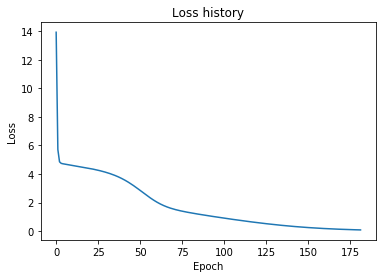

In [6]:
plt.plot(losses)
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')

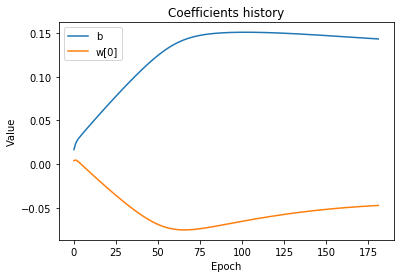

In [7]:
plt.plot(bs, 
         label='b')
plt.plot(ws,
         label='w[0]')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Coefficients history')

plt.legend()

(5, 16)


Text(0.5, 1.0, 'V')

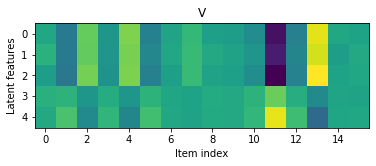

In [8]:
print(mod.v.shape)
plt.imshow(mod.v.numpy())
plt.ylabel('Latent features')
plt.xlabel('Item index')
plt.title('V')